<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_09_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
from nltk.chat.util import Chat, reflections

What are *reflections*?

In [ ]:
print(reflections)

{'i am': 'you are', 'i was': 'you were', 'i': 'you', "i'm": 'you are', "i'd": 'you would', "i've": 'you have', "i'll": 'you will', 'my': 'your', 'you are': 'I am', 'you were': 'I was', "you've": 'I have', "you'll": 'I will', 'your': 'my', 'yours': 'mine', 'you': 'me', 'me': 'you', 'hello': 'hi', 'bye': 'see you', 'o/': '\\o', '>': '<'}


We can add stuff.

In [ ]:
reflections['myself'] = 'yourself'

We need to structure what will the bot respond to diverse prompts.

In [ ]:
intro = ['Pleased to meet you, %1.', "Hello, %1, how's it going?",]
smalltalk = [ 'I am well, thanks', 'Okay',]
identify = ['I am a bot',]
positive = [ 'Nice', 'Excellent', 'Way to go', 'Good for you',]
negative = [ 'That sucks', 'Sorry to hear that', ':(',]
default = [ 'Wow', 'I hear you',]
questionResponse = [ # will be matched in this order
    [ r'my name is (.*)', intro ],
    [ r'I am (.*)', intro ],
    [ r'this is (.*)', intro ],
    [ r'who am I talking to|who is this', identify ],
    [ r"how are you|how about you|what's up", smalltalk ],
    [ r'not too bad|fine|well|great', positive ],
    [ r'bad|sucks', negative ],
    [ r'bonjour|hi|whazzup (.*)', ['ohai', 'Bonjour, ça va?',] ], 
    [ r'sorry (.*)', ['no biggie',] ],
    [ r'close|farewell (.*)', ['It was a pleasure', 'See you later',] ],
    [ r'(.*)\!', ['%1, for sure'] ],
    [ r'(.*)\?', ['whoah, %1!',] ],
    [ r'(.*)', default ]
]

Let's start a chat :)

In [ ]:
print('At your service, mate.')
chat = Chat(questionResponse, reflections)
chat.converse(quit = 'close') # typing close will make it stop expecting more messages

At your service, mate.
>the weather sucks today
Wow
>who is this?
I am a bot
>I am elisa
Hello, elisa, how's it going?
>well, thanks
Way to go
>nice to meet you
I hear you
>my cat climbed on my table
Wow
>do you have a cat?
whoah, do me have a cat!
>close
It was a pleasure


So that is a *rule-based* chat bot. Another approach is to use machine learning and figure out based on training data what are appropriate responses for the bot. We will now start working towards that latter direction, following an [online Pykit tutorial](https://pykit.org/chatbot-in-python-using-nlp/).  The training data is a [JSON file](https://github.com/vishal-verma27/Building-a-Simple-Chatbot-in-Python-using-NLTK/blob/611bc5c96f25aa0e5f8e71a97c421fab7781214e/Train_Bot.json) that is similar to the rules above in the sense that it associates *patterns* to *responses*.

In [6]:
from urllib.request import urlopen
import json
url = 'https://raw.githubusercontent.com/vishal-verma27/Building-a-Simple-Chatbot-in-Python-using-NLTK/611bc5c96f25aa0e5f8e71a97c421fab7781214e/Train_Bot.json'
data = urlopen(url) 
intents = json.loads(data.read())
print(json.dumps(intents, indent = 2))

{
  "intents": [
    {
      "tag": "Intro",
      "patterns": [
        "hi",
        "how are you",
        "is anyone there",
        "hello",
        "whats up",
        "hey",
        "yo",
        "listen",
        "please help me",
        "i am learner from",
        "i belong to",
        "aiml batch",
        "aifl batch",
        "i am from",
        "my pm is",
        "blended",
        "online",
        "i am from",
        "hey ya",
        "talking to you for first time"
      ],
      "responses": [
        "Hello! how can i help you ?"
      ],
      "context_set": ""
    },
    {
      "tag": "Exit",
      "patterns": [
        "thank you",
        "thanks",
        "cya",
        "see you",
        "later",
        "see you later",
        "goodbye",
        "i am leaving",
        "have a Good day",
        "you helped me",
        "thanks a lot",
        "thanks a ton",
        "you are the best",
        "great help",
        "too good",
        "you are a good l

Now we do some of our newly-acquired NLP tricks on that data to train a model.

In [16]:
import nltk
nltk.download('punkt') # once per machine
nltk.download('wordnet') # same
nltk.download('omw-1.4') # same

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [79]:
l = nltk.WordNetLemmatizer()
words = set()
documents = list()
classes = set()
for i in intents['intents']:
  t = i['tag']
  classes.add(t)
  for p in i['patterns']:
    tokens = set([ l.lemmatize(w.lower()) for w in nltk.word_tokenize(p) ])
    documents.append((tokens, t))
    words |= tokens

Let's take a look at what we have.

In [86]:
words = sorted(list(words))
classes = sorted(list(classes))
print(words[:10])
print(words[-10:])
print(classes)
print(len(documents))

['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an']
['who', 'whom', 'window', 'with', 'work', 'working', 'ya', 'yo', 'you', 'your']
['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
128


Now we can make a training set associating bags of words to the classes (tags).

In [91]:
training = []
k = len(classes)
for (pattern, tag) in documents:
    # binary yes/no for which words appear in a pattern
    BoW = [ 1 * (w in pattern) for w in words ] # 1 if word in pattern, 0 if not 
    label = [0] * k # a blank slate for one-hot
    label[classes.index(tag)] = 1 # this is the desired class
    training.append([BoW, label])
print(len(training))
for t in range(5):
  bag, tag = training[t]
  print(sum(bag), tag)
for t in range(5):
  bag, tag = training[-t]
  print(sum(bag), tag)

128
1 [0, 0, 1, 0, 0, 0, 0, 0]
3 [0, 0, 1, 0, 0, 0, 0, 0]
3 [0, 0, 1, 0, 0, 0, 0, 0]
1 [0, 0, 1, 0, 0, 0, 0, 0]
2 [0, 0, 1, 0, 0, 0, 0, 0]
1 [0, 0, 1, 0, 0, 0, 0, 0]
3 [0, 0, 0, 0, 0, 0, 0, 1]
2 [0, 0, 0, 0, 0, 0, 0, 1]
3 [0, 0, 0, 0, 0, 0, 0, 1]
2 [0, 0, 0, 0, 0, 0, 0, 1]


We should put that in random order.

In [92]:
from random import shuffle
shuffle(training)
# just going to use all of it, we are not just now interested in saving some for testing
X = [ t[0] for t in training ]
Y = [ t[1] for t in training ]
print(len(X), len(Y))

128 128


We can train a model now. As in the tutorial, we pick a sequential neural network.

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
n = len(X)
h = len(X[0])
k = len(Y[0])
print(n, h, k)
m = Sequential()
t = 0.5
a = 'relu'
m.add(Dense(n, input_shape = (h, ), activation = a))
m.add(Dropout(t))
m.add(Dense(n // 2, activation = a))
m.add(Dropout(t))
m.add(Dense(n // 2, activation = a))
m.add(Dense(k, activation = 'softmax')) # just pick one class
print(m.summary())

128 158 8
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 128)               20352     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_75 (Dense)            (None, 64)                4160      
                                                                 
 dense_76 (Dense)            (None, 8)                 520       
                                                                 
Total params: 33,288
Trainable params: 33,2

So what did we build?

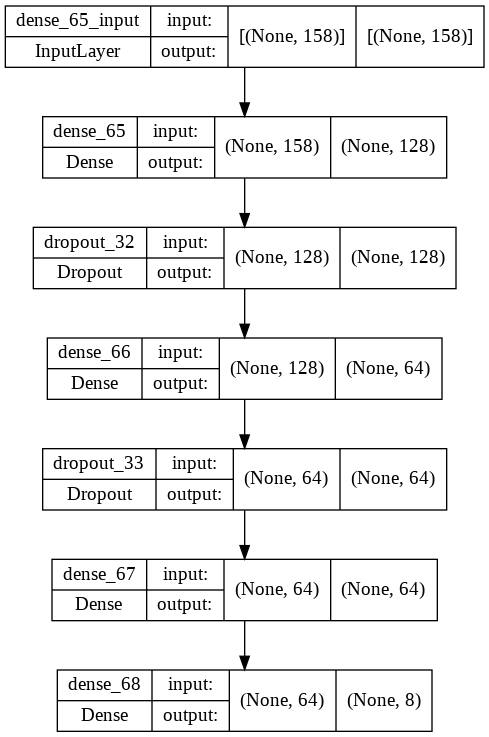

In [94]:
from tensorflow.keras.utils import plot_model
plot_model(m, show_shapes = True, show_layer_names = True)

Set up the fitting and get on with it.

In [102]:
m.compile(loss = 'categorical_crossentropy', 
          optimizer = SGD(learning_rate = 0.01, 
                          decay = 1e-5, 
                          momentum = 0.8, 
                          nesterov = True), 
          metrics = ['categorical_accuracy'])
import numpy as np
f = m.fit(np.array(X), np.array(Y), epochs = 100, batch_size = 10, verbose = 1) # just a little for a quick demo

Epoch 1/100
13/13 [==============================] - 1s 2ms/step - loss: 2.0911 - categorical_accuracy: 0.1094
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 2.0274 - categorical_accuracy: 0.1953
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 2.0204 - categorical_accuracy: 0.2266
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 1.9929 - categorical_accuracy: 0.2031
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 1.9781 - categorical_accuracy: 0.2344
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 1.9746 - categorical_accuracy: 0.2188
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 1.9108 - categorical_accuracy: 0.2578
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 1.9244 - categorical_accuracy: 0.2188
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 1.9026 - categorical_accuracy: 0.2812
E

Now, how do we use this model to generate bot responses? We need to figure out the tag for whatever the user writes and then pick a response based on that.

In [122]:
userinput = input('Write here to what you want the bot to respond: ')

Write here to what you want the bot to respond: This service sucks, I have been waiting for ever.


In [123]:
uw = set([ l.lemmatize(w) for w in nltk.word_tokenize(userinput) ])
BoW = [ 1 * (w in uw) for w in words ]
print(len(BoW))
threshold = 0.3 # discard unpromising results
p = m.predict(np.array([BoW]))[0] # predict just this one data point
print(classes) # reminder
for outcome, label in zip(p, classes):
  if outcome > threshold: # could be a match
    print(outcome, label)

158
['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
0.74491495 Intro


If there is a clear winner, we can just use that.

In [124]:
best = np.argmax(p) # use the highest as our match
chosen = classes[best] # the class to use to respond
print(f'Chose class {chosen}')
from random import choice # we pick one at random
for i in intents['intents']:
  if i['tag'] == chosen: 
    print(choice(i['responses']))
    break

Chose class Intro
Hello! how can i help you ?


You can go run the cell above that takes a user input to try again.